# AmicalSat ShockBurst image packets processing

This notebook shows how to process ShockBurst S-band image packets to reassemble the image file

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

The data `shockburst.u8` contains ShockBurst frames without the `0xE7E7E7E7E7` address header (including frame counter, image payload and CRC). It has been obtained with `nrf24.grc`.

In [2]:
data = np.fromfile('/home/daniel/debian_testing_chroot/tmp/shockburst.u8', dtype = 'uint8').reshape((-1,34))

The CRC used in ShockBurst frames CRC16_CCITT_FALSE from [this online calculator](http://www.sunshine2k.de/coding/javascript/crc/crc_js.html). Since the `0xE7E7E7E7E7` address is included in the CRC calculation but is missing in our data, we take this into account by modifying the initial XOR value.

In [3]:
crc_table = [
    0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0
]

def crc(frame):
    c = 0xB95E # CRC of initial E7E7E7E7E7 address field
    for b in frame:
        tbl_idx = ((c >> 8) ^ b) & 0xff
        c = (crc_table[tbl_idx] ^ (c << 8)) & 0xffff

    return c & 0xffff

In [4]:
crc_ok = np.array([crc(d) == 0 for d in data])
frame_count = data[crc_ok,:2].ravel().view('uint16')

In [10]:
frame_count_unique = np.unique(frame_count)

Number of skipped frames:

In [11]:
np.sum(np.diff(frame_count_unique)-1)

5

In [15]:
np.where(np.diff(frame_count_unique)-1)

(array([270, 284, 351]),)

Number of correct frames:

In [12]:
len(frame_count_unique)

2555

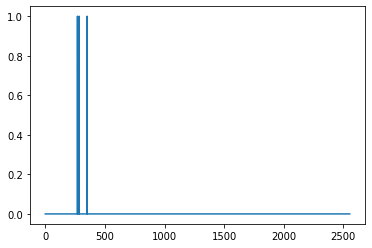

In [13]:
plt.plot(np.diff(frame_count_unique)!=1)

Write frames to a file according to their frame number. We do a majority voting to select among different frames with the same frame number (there are corrupted frames with good CRC). The file has gaps with zeros where frames are missing.

In [17]:
frame_size = 30
with open('/tmp/file', 'wb') as f:
    for count in frame_count_unique:
        valid_frames = data[crc_ok][frame_count == count]
        counter = Counter([bytes(frame[2:]) for frame in valid_frames])
        f.seek(count * frame_size)
        f.write(counter.most_common()[0][0])